# Clustering

# Índice 
1. [Introduction](#introduction)
2. [Import Materials](#importmaterials)    
    2.1. [Import Libraries](#importlibraries)     
    2.2. [Import the dataset](#importdataset)
3. [Clusterings](#clustering)    
    3.1. [Hierarchical Clustering](#hierarchical)   
    3.2. [K Means](#kmeans)     
    3.3. [SOM](#som)   
    3.4. [Mean Shift Clustering](#mean)    
    3.5. [DBSCAN](#dbscan)         
    3.6. [Gaussian Mixure Model](#gmm)  

<hr>
<a class="anchor" id="introduction">
    
# 1. Introduction
    
</a>


This notebook analyzes customer data from ABCDEats Inc., a fictional food delivery service, over three months. The goal is to create clusters of customers and make different marketing startegies for each of them....    
**Project by** Dinis Pinto (20240612), Joana Rodrigues (20240603), João Marques (20240656), and Mara Simões (20240326) - **Group 27**.

<hr>
<a class="anchor" id="importmaterials">
    
# 2. Import Materials
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 2.1. Import Libraries
    
</a>

For this project, we'll install some helpful libraries to make analysis easier and add features like better plotting, data handling, and modeling tools. For example, `matplotlib` and `seaborn` allow us to create clear, customizable plots, while `pandas` and `numpy` make data processing smoother.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from minisom import MiniSom
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import pickle
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import Colorbar
from sklearn.cluster import estimate_bandwidth, MeanShift
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram
from sklearn.base import clone

<hr>
<a class="anchor" id="importdataset">
    
## 2.2. Import Dataset
    
</a>

### Data in dataset
The different columns in the dataset give out the following information:   
- `customer_id` - Unique identifier for each customer.
- `customer_region` - Geographic region where the customer is located.
- `customer_age` - Age of the customer.
- `vendor_count` - Number of unique vendors the customer has ordered from.
- `product_count` - Total number of products the customer has ordered.
- `is_chain` - Indicates whether the customer’s order was from a chain restaurant.
- `first_order` - Number of days from the start of the dataset when the customer first placed an order.
- `last_order` - Number of days from the start of the dataset when the customer most recently placed an order.
- `last_promo` - The category of the promotion or discount most recently used by the customer.
- `payment_method` - Method most recently used by the customer to pay for their orders.
- `CUI_American`, `CUI_Asian`, `CUI_Chinese`, `CUI_Italian`... - The amount in monetary units spent by the customer from the indicated type of cuisine. 
- `DOW_0` to `DOW_6` - Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday).
- `HR_0` to `HR_23` - Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

In [2]:
df_preferences = pickle.load(open("df_preferences.pkl", 'rb'))

In [3]:
# Creating an assessment table
results_df = pd.DataFrame(columns=["Silhouette_Score", "R2"])
results_df.index.name = 'Method'

<hr>
<a class="anchor" id="clustering">
    
# 3. Clustering Algorithms
    
</a>

### Function for plotting R2 for various clustering algorithms

In [4]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

def get_r2(df, labels):
    sst = get_ss(df)  
    ssw_labels = df.groupby(labels).apply(get_ss)  
    ssb = sst - np.sum(ssw_labels) 
    r2 = ssb / sst 
    return r2
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = get_r2(df, labels)
    return r2_clust

<a class="anchor" id="hierarchical">
    
## 3.1. Hierarchical Clustering
</a>

Hierarchical clustering is used to group similar data points into clusters based on similarity. It forms a hierarchical structure known as a dendrogram where we can visualize how clusters are combined or separated at each step. 

Hierarchical clustering creates a hierarchy of clusters by either starting with all points in a single cluster and splitting them recursively (divisive) or by starting with each point in its own cluster and merging them (agglomerative). In this project, we are going to use agglomerative clustering.

We start by define the best linkage method and plot the dendrogram to choose the optimal number of clusters. To help decide the optimal number of clusters, we compared the mean values of the variables and used the silhouette score.

### 3.1.1 Defining the best linkage method and the best partitioning method (based on the $R^2$)

The linkage method determines how the distance between clusters is calculated.
- **Ward**: Minimizes the variance within clusters.
- **Complete**: Considers the maximum distance between points in two clusters.
- **Average**: Uses the average distance between points in two clusters.
- **Single**: Considers the minimum distance between points in two clusters.

The highest $R^2$ in a model implies that this explains better the data. In our case, the best hierarchical linkage is Ward.

In [5]:
# Set up the clusterers

kmeans = KMeans(init='k-means++', n_init=20, random_state=42)
hierarchical = AgglomerativeClustering(metric='euclidean')

In [6]:
# Obtaining the R² scores for each cluster solution on behaviour variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_preferences, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']: 
    r2_scores[linkage] = get_r2_scores(
        df_preferences, hierarchical.set_params(linkage=linkage))

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.095474  0.033714  0.001643  0.001021  0.075276
3  0.184473  0.072985  0.003772  0.002664  0.134512
4  0.242381  0.121347  0.005133  0.003188  0.186121
5  0.297632  0.141615  0.006343  0.005317  0.235099
6  0.344127  0.184063  0.008656  0.005947  0.282939
7  0.380164  0.206292  0.013437  0.006268  0.319464
8  0.419159  0.215643  0.018068  0.006689  0.354919
9  0.444060  0.224562  0.027703  0.007056  0.386997

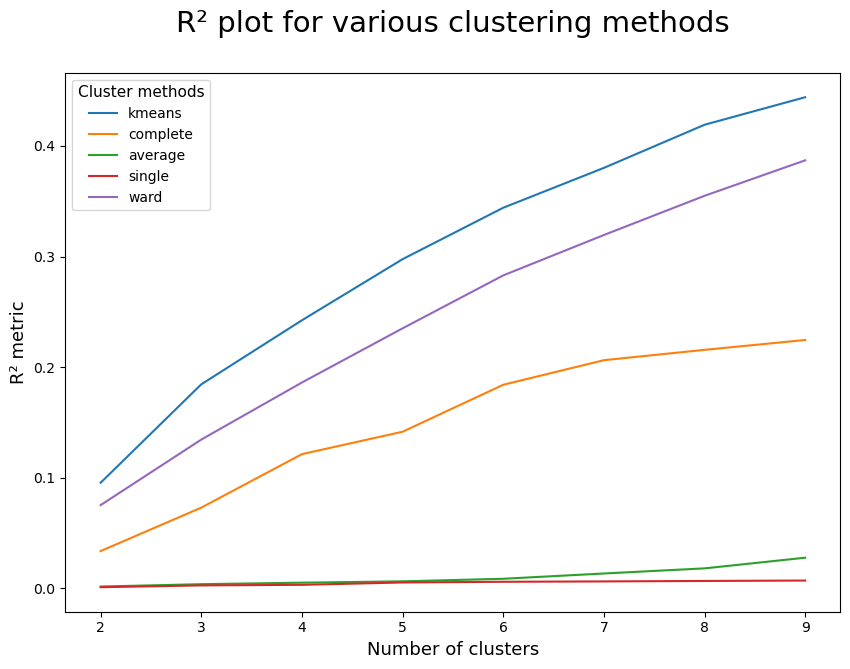

In [7]:
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("R² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

A dendrogram is a tree-like diagram that is used to illustrate the arrangement of clusters created by hierarchical clustering. It represents how data points (or clusters) are merged step-by-step in the hierarchical clustering process. Dendrograms are useful for the following purposes:

- **Visualizing Cluster Relationships**: It shows how clusters are formed and how closely they are related to one another.
- **Determining the Optimal Number of Clusters**: By cutting the dendrogram at a specific height, it is possible to identify the ideal number of clusters. The height reflects the threshold of similarity or distance.

A dendrogram shows how clusters are merged at each step. By cutting the dendrogram at a specific height, we can define the number of clusters. <br>
Analyzing this dendrogram, we can see a clear separation with 4 clusters, making them potential candidates for the optimal number of clusters.

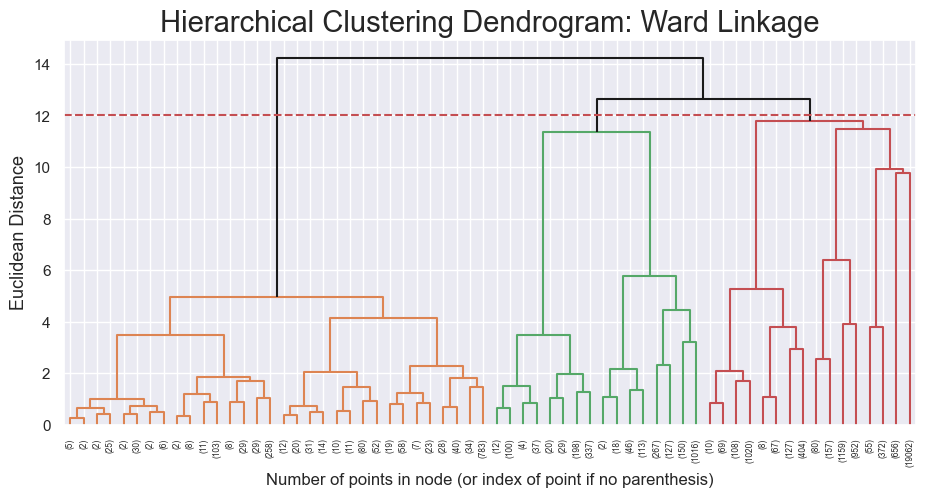

In [8]:
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_preferences)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 12
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### 3.1.2. Hierarchical Clustering - Silhouette Score 

The **silhouette score** helps us assess how well the data points fit into their assigned clusters. It looks at two things: 

- **Cohesion**: How close points are to others in the same cluster.
- **Separation**: How far points are from clusters that are different.

A **higher silhouette score** (closer to 1) means that the clusters are well-defined, with points tightly grouped together and clearly separated from other clusters. A **lower score** (close to 0) suggests that the clusters may overlap, while a **negative score** indicates points might have been placed in the wrong cluster.

By looking at the silhouette score for different numbers of clusters, we can pick the number of clusters that gives the **best score** that can be seen by the higher silhouete score. The goal is to have the less negatives possible, because positives mean that each point correctly belongs to the cluster that it was assigned to.

For hierarchical clustering, the highest silhouette score was observed with 3 clusters, indicating it is the best choice in this case.

In [9]:
# Compute silhouette score for different n_clusters
for n_clusters in [3,4,5,6]:
    hc_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=n_clusters)
    labels = hc_clust.fit_predict(df_preferences)
    silhouette_avg = silhouette_score(df_preferences, labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

Silhouette Score for 3 clusters: 0.2429585592285079
Silhouette Score for 4 clusters: 0.2013186173484405
Silhouette Score for 5 clusters: 0.17451047006605355
Silhouette Score for 6 clusters: 0.18426176820338294


### 3.1.4. Hierarchical Clustering - Final Solution

After the analysis of the sillouete score we conclude that the optimal amount of clusters is 3.

In [10]:
# solution with 3 clusters

hc2_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=3)
hc2_labels = hc2_clust.fit_predict(df_preferences)

df_concat = pd.concat([df_preferences, pd.Series(hc2_labels, name='hierarc_labels', index=df_preferences.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  \
hierarc_labels                                                     
0                   0.021469   0.027901       0.015222  0.007107   
1                   0.268015   0.038221       0.005413  0.000733   
2                   0.022779   0.148550       0.013998  0.000097   

                CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
hierarc_labels                                                               
0                         0.013714     0.009581      0.009802     0.010046   
1                         0.000683     0.005331      0.001490     0.003914   
2                         0.000054     0.002059      0.002764     0.001798   

                CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  \
hierarc_labels                                                             
0                 0.011746     0.017669      0.023824           0.006552   
1                 0.011609     0.018226      0.008312           0.000104   
2                 0.000127     0.000724      0.016221           0.000000   

                CUI_OTHER  CUI_Street Food / Snacks  CUI_Thai  
hierarc_labels                                                 
0                0.026036                  0.003811  0.012272  
1                0.006064                  0.003505  0.003386  
2                0.001002                  0.142475  0.000272

In [11]:
r2 = get_r2(df_preferences, hc2_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_preferences, hc2_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["HC_3"])

results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)

R² Score: 0.13451233828977133
Silhouette Score: 0.2429585592285079


C:\Users\marsi\AppData\Local\Temp\ipykernel_20936\2878212171.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)


<a class="anchor" id="kmeans">

## 3.2. K-Means Algorithm
</a>


### 3.2.1.K- Means - Inertia ( Defining the number of cluster)

Inertia measures how well data points fit into clusters by summing the squared distances between points and their nearest cluster centroid (**SSW**). 

- **Lower inertia**: Clusters are more compact, it's better because it means the datapoints are similar to each other.
- **Higher inertia**: Clusters are less defined.

Using the **elbow method**, we plot inertia for 1 to 10 clusters and look for the "elbow"—the point where inertia stops decreasing significantly. This indicates the optimal number of clusters.

We used a range of clusters starting from k=2 because k=1 indicates that a single cluster represents the entire dataset as one group, which is not meaningful for clustering analysis. Starting from k=2 allows us to divide the data into multiple groups and ensure more interpretable results.

Observing the following inertia plot, we conclude that the optimal number of clusters is 4 or 6. We will investigate this further with other methods.

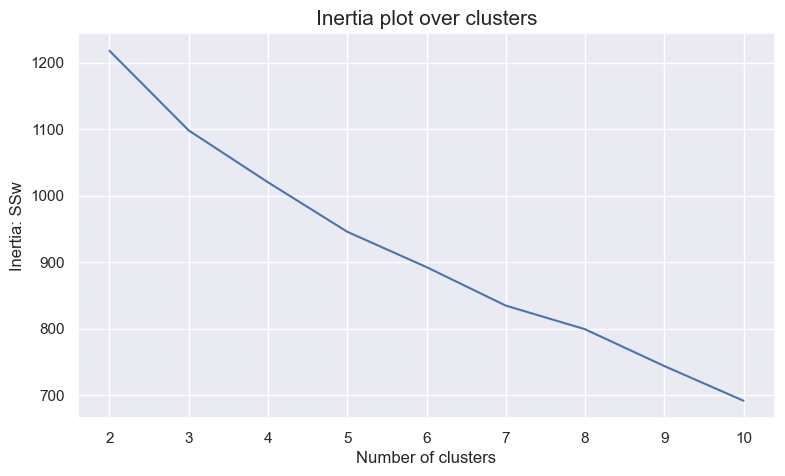

In [12]:
range_clusters = range(2, 11)    # testing between 2 and 10 clusters
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_preferences)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

### 3.2.2. K- Means - Silhouete Score (Defining the number of clusters)

As we saw previously, the silhouette score define how-well separated the clusters are, indicating with a higher score the better clusters. By computing silhouette scores for different numbers of clusters, we can determine the best number of clusters. <br>

The highest silhouette coeficient was obtained with 6 clusters, as it's possible to see.

For n_clusters = 2, the average silhouette_score is : 0.24607013271668432
For n_clusters = 3, the average silhouette_score is : 0.24334513155896714
For n_clusters = 4, the average silhouette_score is : 0.25088205710385486
For n_clusters = 5, the average silhouette_score is : 0.25599998483528363
For n_clusters = 6, the average silhouette_score is : 0.2657683835133451


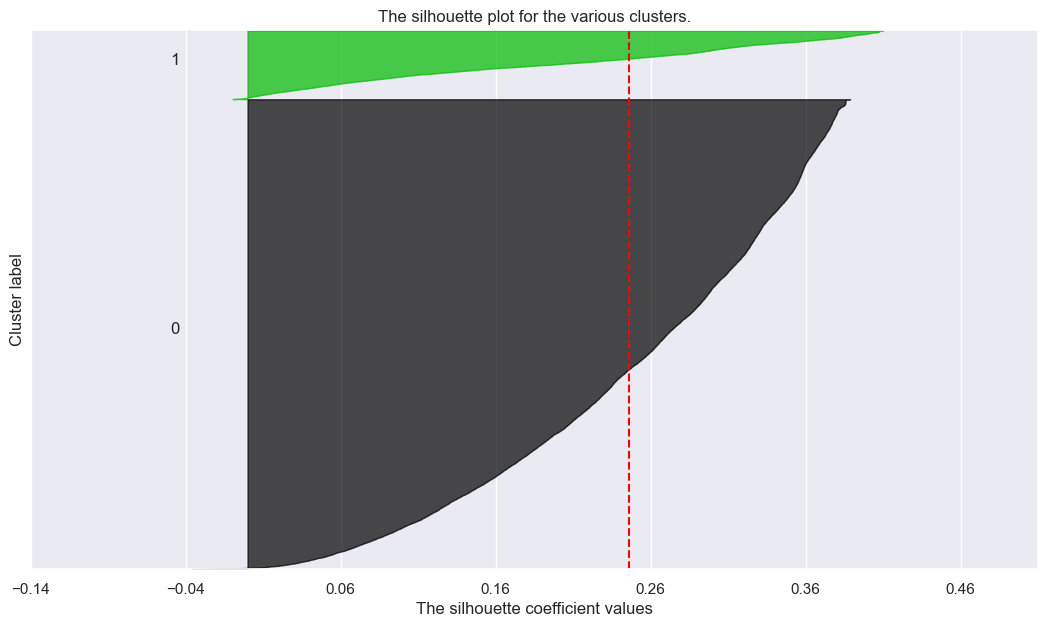

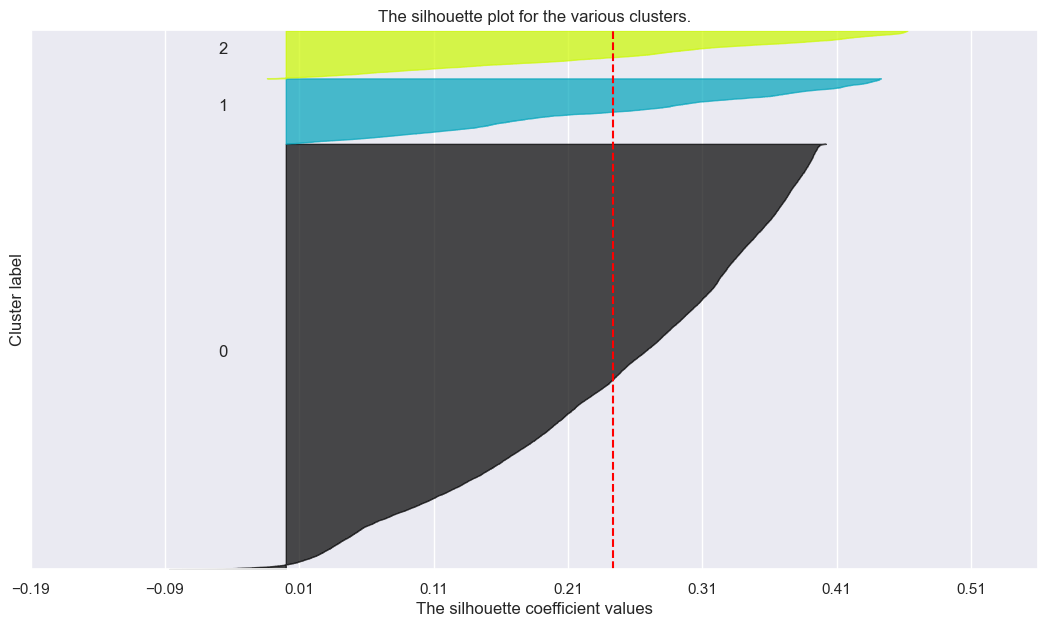

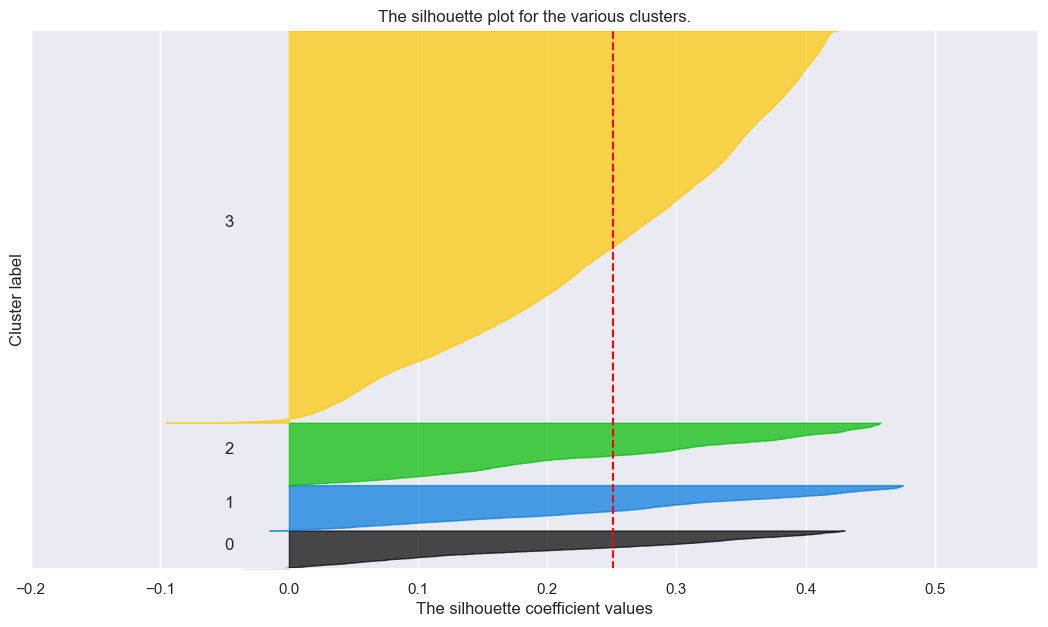

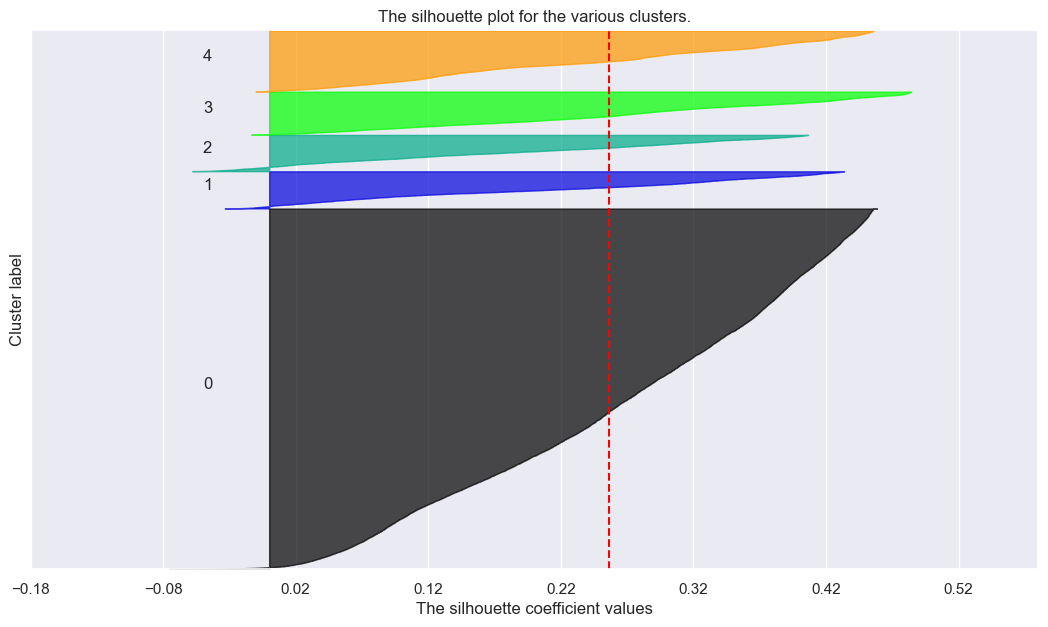

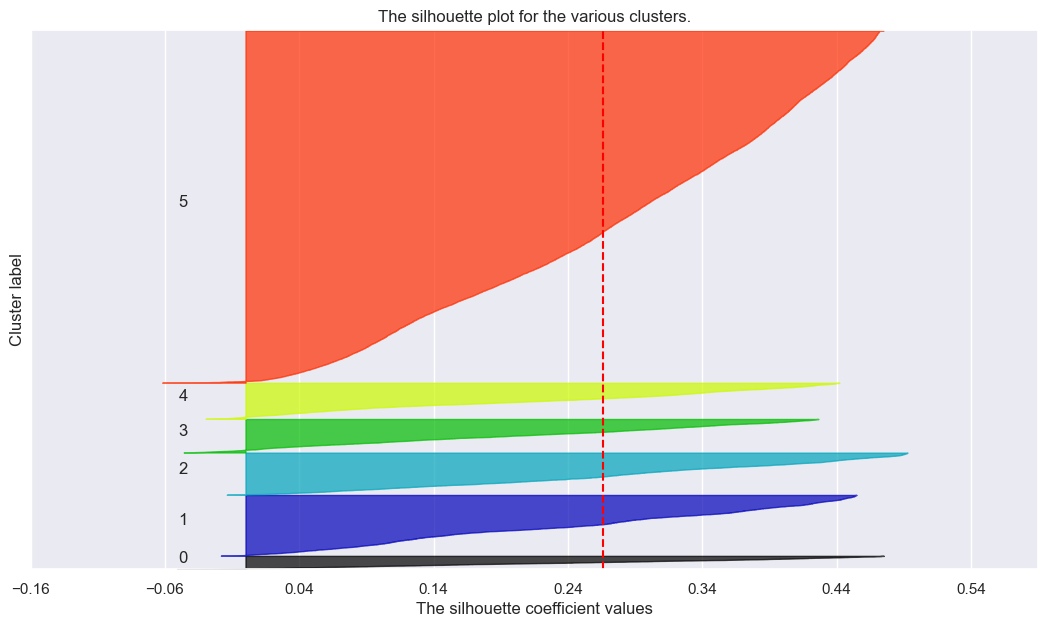

In [13]:
avg_silhouette = []
for nclus in range(2, 7):
    fig = plt.figure(figsize=(13, 7))
    
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_preferences)

    silhouette_avg = silhouette_score(df_preferences, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(df_preferences, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() - 0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(df_preferences) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))

plt.show()

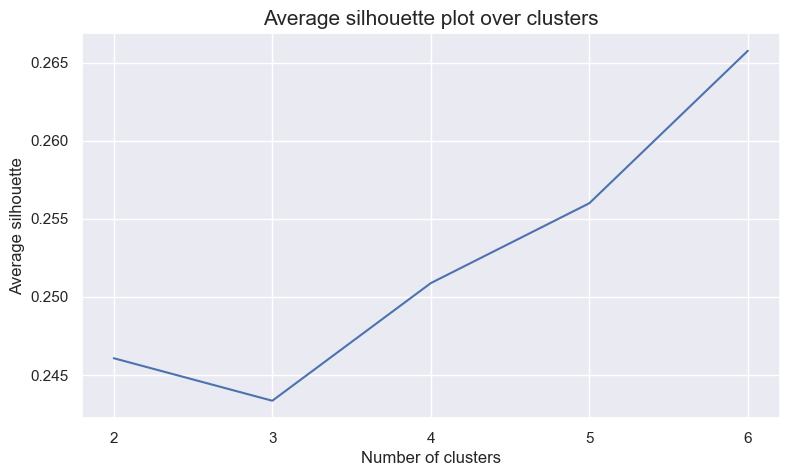

In [14]:
plt.figure(figsize=(9, 5))
plt.plot(range(2, 7), avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.xticks(range(2, 7)) 
plt.show()

### 3.2.3. K-Means - Final Solution
After the analysis of the sillouete score and the inertia plot we conclude that the optimal amount of clusters is 6.

#### 6 clusters

In [15]:
kmclust = KMeans(n_clusters=6, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_preferences)

df_concat = pd.concat((df_preferences, pd.Series(km_labels, name='labels', index=df_preferences.index)), axis=1)
df_concat.groupby('labels').mean()

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  \
labels                                                                         
0           0.027220   0.012574       0.002934  0.010863            0.006683   
1           0.019242   0.216614       0.018318  0.001361            0.000173   
2           0.258304   0.025642       0.008532  0.006488            0.002406   
3           0.022972   0.011801       0.004526  0.015366            0.014283   
4           0.024158   0.027023       0.008180  0.006745            0.002830   
5           0.016077   0.014785       0.016607  0.005759            0.015696   

        CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  \
labels                                                                    
0          0.003989      0.000925     0.007631    0.022374     0.026248   
1          0.005966      0.013336     0.005275    0.001749     0.002579   
2          0.005598      0.006293     0.004912    0.007485     0.018062   
3          0.007693      0.001726     0.009540    0.015071     0.022955   
4          0.006158      0.007889     0.008396    0.006365     0.012570   
5          0.010026      0.009200     0.010125    0.012261     0.017726   

        CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_Street Food / Snacks  \
labels                                                                         
0           0.016042           0.001869   0.023475                  0.000868   
1           0.010791           0.000134   0.001869                  0.030377   
2           0.012314           0.000236   0.010067                  0.012527   
3           0.013112           0.005753   0.225036                  0.002005   
4           0.219399           0.001841   0.007351                  0.015485   
5           0.006320           0.007677   0.010031                  0.015625   

        CUI_Thai  
labels            
0       0.291378  
1       0.000934  
2       0.003572  
3       0.007868  
4       0.004828  
5       0.003555

In [16]:
r2 = get_r2(df_preferences, km_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_preferences, km_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["KMeans_6"])

results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)
# results_df

R² Score: 0.3371205188620694
Silhouette Score: 0.2657683835133451


<a class="anchor" id="som">

## 3.3. Self-Organizing Maps (SOM)
</a>
 Self-Organizing Map (SOM) is a type of neural network used for for dimensionality reduction and visualization of high-dimensional data. It maps high-dimensional data into a lower-dimensional (typically 2D) grid while preserving the topological structure of the data. This makes SOM useful for clustering, pattern recognition, and visualizing complex relationships in datasets.

In [17]:
data_som = df_preferences.copy()

In [18]:
num_data_points = data_som.shape[0]
print("Nr. of data points:" , num_data_points)

print("Mapsize:" , 5*(num_data_points)**(1/2)) 

Nr. of data points: 28526
Mapsize: 844.4820898041592


In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def get_neighbors_hexagonal(som, node):
    """Get hexagonal neighbors of a node."""
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]: 
            neighbors.append((nx, ny))
    return neighbors

MiniSom.get_neighbors = get_neighbors_hexagonal  

def calculate_topographic_error(som, data):
    """Calculate topographic error for SOM."""
    errors = 0
    for sample in data:
        bmu_1 = som.winner(sample)  
        distances = np.linalg.norm(som._weights - sample, axis=-1) 
        bmu_2 = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)  
        neighbors = som.get_neighbors(bmu_1)
        if bmu_2 not in neighbors:
            errors += 1
    return errors / len(data)


def evaluate_scaling_methods(data, scaling_methods, M=20, N=20, iterations=500):
    results = []
    for method_name, scaler in scaling_methods.items():
        scaled_data = scaler.fit_transform(data)
        
        som = MiniSom(M, N, scaled_data.shape[1], sigma=5.0, learning_rate=0.5, random_seed=42)
        som.random_weights_init(scaled_data)
        som.train(scaled_data, iterations)
        
        qe = som.quantization_error(scaled_data)
        te = calculate_topographic_error(som, scaled_data)
        
        results.append({"Scaling Method": method_name, "QE": qe, "TE": te})
    
    return pd.DataFrame(results)

scaling_methods = {"Min-Max Scaling": MinMaxScaler(), "Standardization": StandardScaler(), "Robust Scaling": RobustScaler()}

results = evaluate_scaling_methods(df_preferences.values, scaling_methods)
print(results)

    Scaling Method        QE        TE
0  Min-Max Scaling  0.093632  0.116946
1  Standardization  1.568655  0.167917
2   Robust Scaling  0.223388  0.228353


The best scaler for us is MinMax Scaler so we are going to keep it.

### 3.3.1. Finding the best choice of parameters and training the SOM

Quantization Error and Topographic Error are two important metrics used to evaluate the performance of a Self-Organizing Map:

- **Quantization Error (QE)**:
    - Measures the average distance between each data point and its Best Matching Unit (BMU) on the SOM grid.
    - Lower QE is better: it means the SOM is better at clustering the data points close to their BMUs.
- **Topographic Error (TE)**:
    - Measures how well the SOM preserves the structure (topology) of the input data.
    - Lower TE is better: it means that the SOM maintains the topology of the original data (0 indicates excellent topographic representation and 1 is the maximum error).

In [20]:
import itertools

def grid_search_som(data, param_grid):

    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()

    results = []
    for params in itertools.product(*param_grid.values()):
        grid_size, sigma, learning_rate, iterations = params
        som = MiniSom(
            x=grid_size[0], y=grid_size[1],
            input_len=data.shape[1],
            sigma=sigma, learning_rate=learning_rate,
            random_seed=42, neighborhood_function='gaussian')
        
        som.random_weights_init(data)
        som.train(data, iterations)

        qe = som.quantization_error(data)
        te = calculate_topographic_error(som, data)

        results.append({
            'Grid Size': grid_size,
            'Sigma': sigma,
            'Learning Rate': learning_rate,
            'Iterations': iterations,
            'Quantization Error': qe,
            'Topographic Error': te})

    return pd.DataFrame(results)

def get_neighbors_hexagonal(som, node):
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]:
            neighbors.append((nx, ny))
    return neighbors

MiniSom.get_neighbors = get_neighbors_hexagonal

In [21]:
param_grid = {
    'grid_size': [(30, 30)],
    'sigma': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0],
    'iterations': [500, 1000]}

In [22]:
grid_search = grid_search_som(df_preferences, param_grid)

c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


In [23]:
grid_search['Combined Score'] = grid_search['Quantization Error'] + grid_search['Topographic Error']
best_row_idx = grid_search['Combined Score'].idxmin()
best_params = grid_search.loc[best_row_idx]
print("Best Parameters:")
print(best_params)

Best Parameters:
Grid Size             (30, 30)
Sigma                      3.0
Learning Rate              1.5
Iterations                1000
Quantization Error    0.058185
Topographic Error     0.197679
Combined Score        0.255865
Name: 57, dtype: object


In [24]:
grid_search.sort_values(by='Combined Score', ascending=True).head()

Grid Size  Sigma  Learning Rate  Iterations  Quantization Error  \
57  (30, 30)    3.0            1.5        1000            0.058185   
53  (30, 30)    3.0            0.5        1000            0.062178   
55  (30, 30)    3.0            1.0        1000            0.059432   
43  (30, 30)    2.5            0.5        1000            0.060757   
56  (30, 30)    3.0            1.5         500            0.062663   

    Topographic Error  Combined Score  
57           0.197679        0.255865  
53           0.195997        0.258175  
55           0.211596        0.271028  
43           0.224532        0.285289  
56           0.252296        0.314959

#### 3.3.1.1. Training SOM on the best parameters

In [25]:
from minisom import MiniSom

best_grid_size = (30, 30)
best_sigma = 3.0
best_learning_rate = 1.0
best_iterations = 1000

som = MiniSom(
    x=best_grid_size[0], 
    y=best_grid_size[1], 
    input_len=df_preferences.shape[1],
    sigma=best_sigma, 
    learning_rate=best_learning_rate,
    neighborhood_function='gaussian',
    random_seed=42)

df_preferences_np = df_preferences.to_numpy()

som.pca_weights_init(df_preferences_np)

print("PCA weights init")
print("Before training:")
qe_before = np.round(som.quantization_error(df_preferences_np), 5)
te_before = np.round(calculate_topographic_error(som, df_preferences_np), 5)
print(f"QE: {qe_before}, TE: {te_before}")

som.train(df_preferences_np, best_iterations)

print("After training:")
qe_after = np.round(som.quantization_error(df_preferences_np), 5)
te_after = np.round(calculate_topographic_error(som, df_preferences_np), 5)
print(f"QE: {qe_after}, TE: {te_after}")


# som = MiniSom(
#     x=best_grid_size[0], 
#     y=best_grid_size[1], 
#     input_len=df_preferences.shape[1],
#     sigma=best_sigma, 
#     learning_rate=best_learning_rate,
#     neighborhood_function='gaussian',
#     random_seed=42
# )

# som.random_weights_init(df_preferences_np)

# print("Random weights init")
# print("Before training:")
# qe_before = np.round(som.quantization_error(df_preferences_np), 5)
# te_before = np.round(calculate_topographic_error(som, df_preferences_np), 5)
# print(f"QE: {qe_before}, TE: {te_before}")

# som.train(df_preferences_np, best_iterations)

# print("After training:")
# qe_after = np.round(som.quantization_error(df_preferences_np), 5)
# te_after = np.round(calculate_topographic_error(som, df_preferences_np), 5)
# print(f"QE: {qe_after}, TE: {te_after}")

PCA weights init
Before training:
QE: 0.15273, TE: 0.0
After training:
QE: 0.06041, TE: 0.21044


- Regarding QE, the average distance between data points and their BMU decreased significantly (SOM has learned to better represent the data).
- TE has increased, meaning that approximately 20% of the data points now have BMUs and second BMUs that are not adjacent on the SOM grid. <br>
This suggest that while SOM has improved in representing the data, it has become less efective at preserving the topological structure of the input data. However, these results with the PCA weights initialization are better than with random weights initialization.

In [26]:
def convert_map_to_euclidean(i, j):
    x = i + 0.5 * (j % 2) 
    y = j * (np.sqrt(3) / 2)
    return x, y

def plot_hexagons(ax, colornorm, matrix_vals, label="", annot=False, cmap=None):
    """
    Plots the values in 'matrix_vals' using hexagonal cells.
    
    Parameters:
    -----------
    ax : matplotlib Axes
        The axes on which to draw the hexagons.
    colornorm : matplotlib.colors.Normalize
        Normalization object for mapping values to [0, 1].
    matrix_vals : 2D array
        Values to be visualized. shape = (M, N).
    label : str, optional
        Title label for the subplot.
    annot : bool, optional
        If True, numeric values are shown inside each hex.
    cmap : matplotlib.colors.Colormap or None, optional
        Colormap to use. Defaults to 'inferno' if None is provided.
    """
    if cmap is None:
        cmap = cm.coolwarm

    rows, cols = matrix_vals.shape
    for i in range(rows):
        for j in range(cols):
            x, y = convert_map_to_euclidean(i, j)
            value = matrix_vals[i, j]
            hex_color = cmap(colornorm(value))
            hex_patch = RegularPolygon((x, y), numVertices=6, radius=np.sqrt(1 / 3), facecolor=hex_color, alpha=1, edgecolor="white", linewidth=0.5)
            ax.add_patch(hex_patch)

            if annot:
                annot_val = int(np.round(value))
                ax.text(x, y, annot_val, ha="center", va="center", fontsize="x-small",)

    ax.margins(0.05)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(label)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = cm.ScalarMappable(norm=colornorm, cmap=cmap)
    sm.set_array([])
    Colorbar(ax=cax, mappable=sm, orientation="vertical")

### 3.3.2. Visualizing Component Planes of the SOM for Feature Analysis

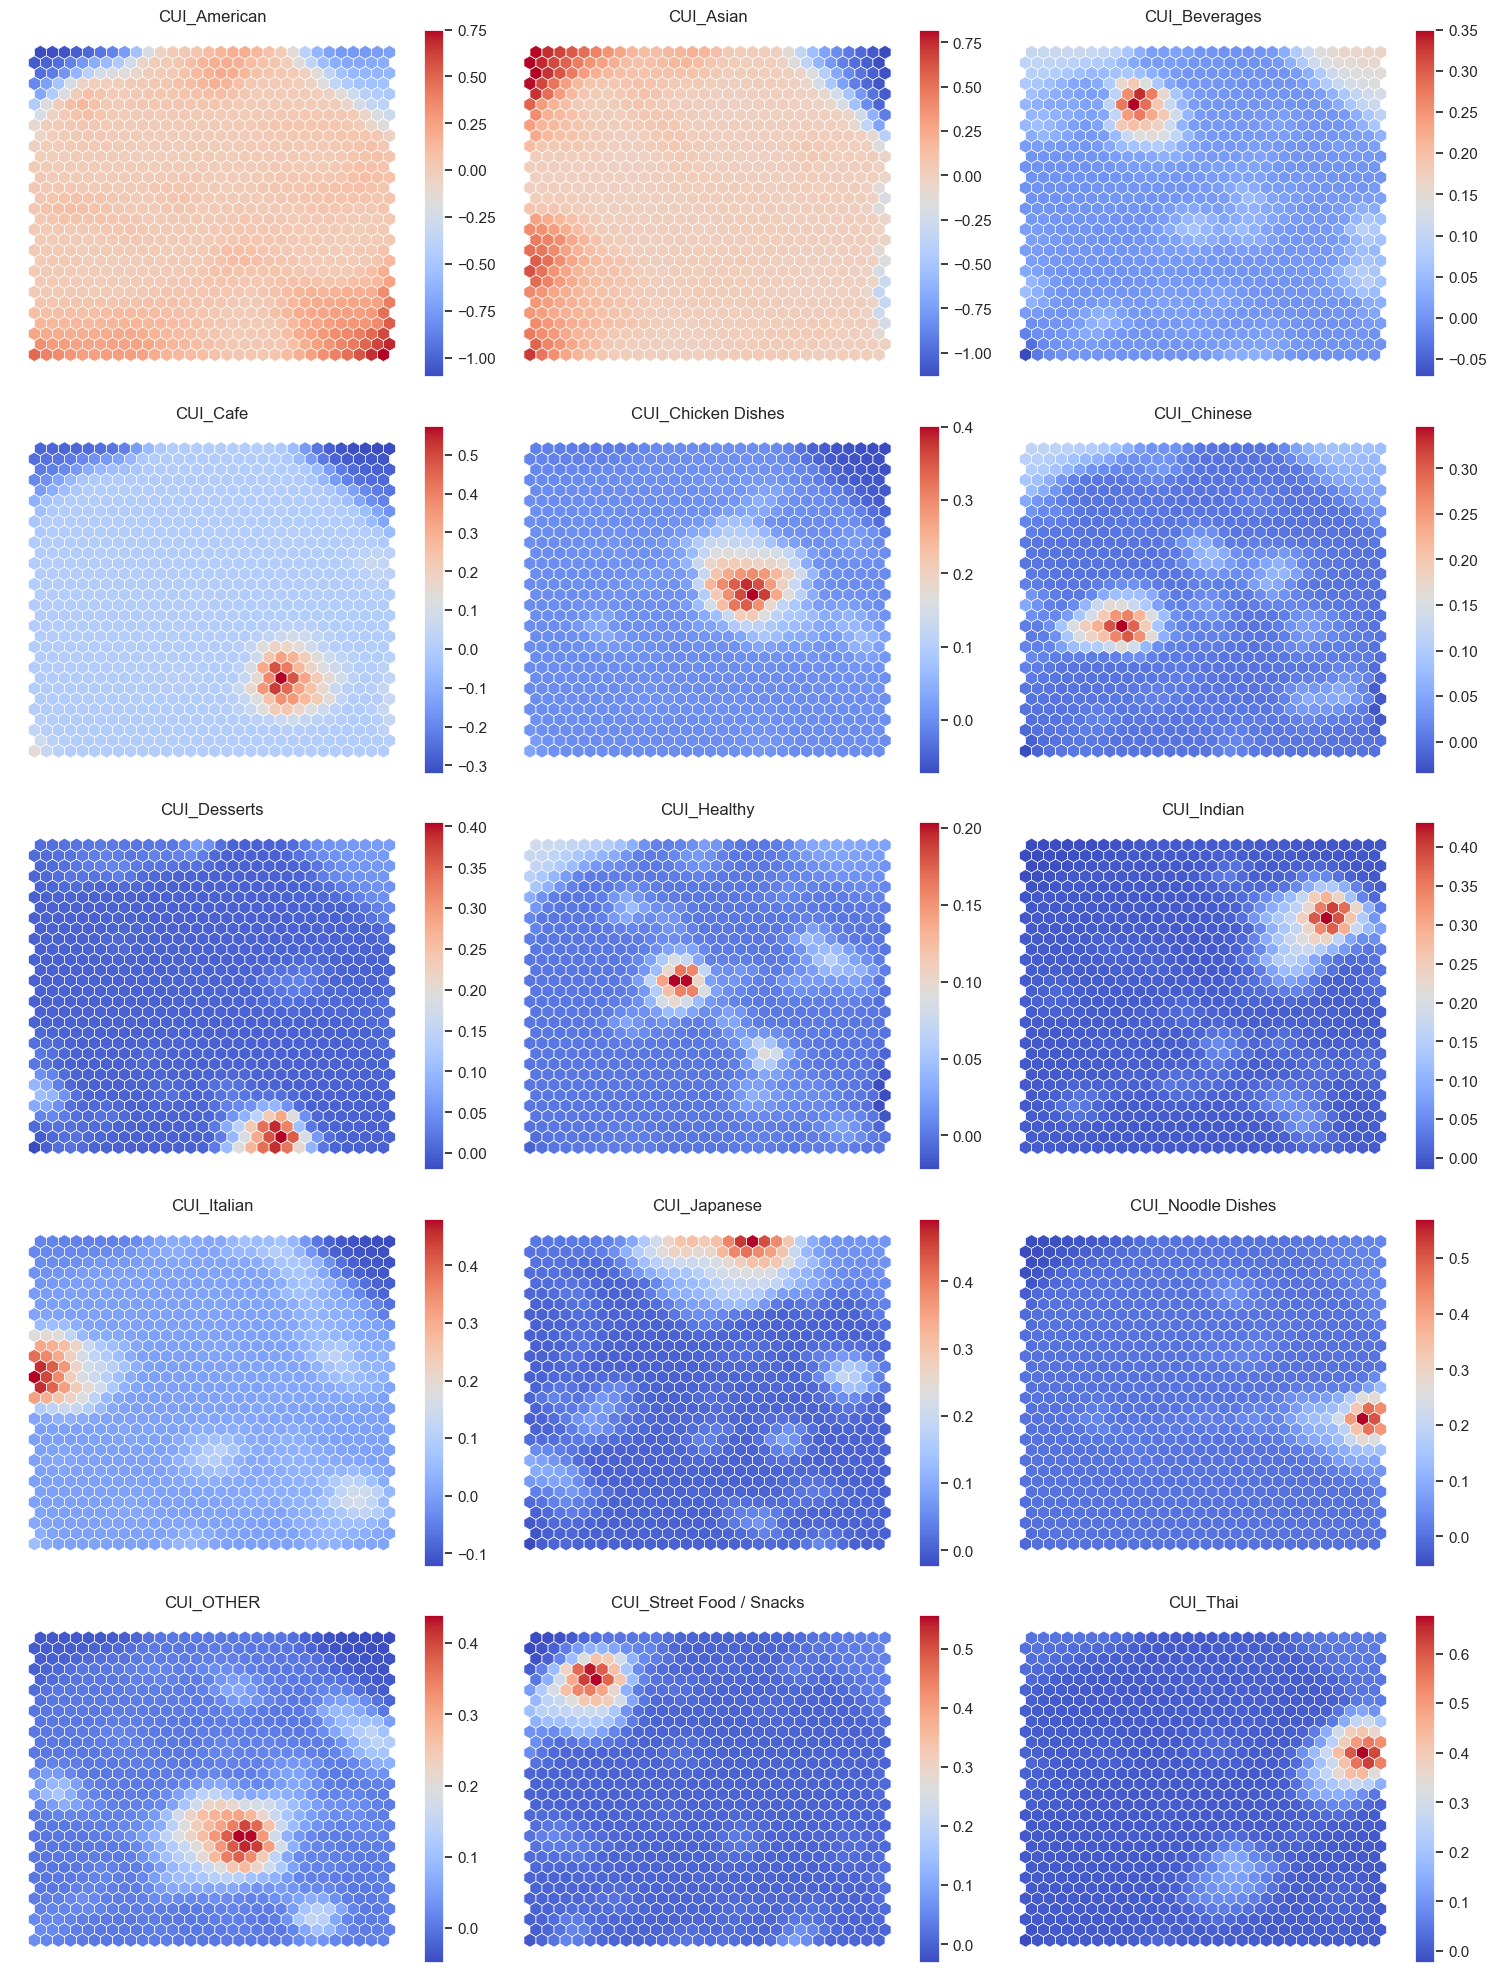

In [27]:
from matplotlib.colors import Normalize

weights = som.get_weights()  
num_features = weights.shape[2]
feature_names = df_preferences.columns

rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 20))  
axes = axes.flatten() 

for i in range(min(num_features, rows * cols)):
    plane = weights[:, :, i]  
    ax = axes[i]

    colornorm = Normalize(vmin=plane.min(), vmax=plane.max())
    
    plot_hexagons(ax=ax, colornorm=colornorm, matrix_vals=plane, label=feature_names[i], annot=False)

for j in range(min(num_features, rows * cols), rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Clustered Spending Behavior:

- High-intensity regions (red/orange hexagons) represent higher money spent on specific cuisines.
- These regions are well-separated for some cuisines, indicating distinct customer groups with specific preferences.

Overlap Across Cuisines:
- Some cuisines, such as CUI_Italian and CUI_OTHER, show dispersed high-intensity regions, suggesting that many different types of customers are interested in these cuisines.
- Niche Preferences: certain cuisines, like CUI_Indian, have isolated high-intensity clusters in specific regions, indicating it appeals strongly to a specific group of customers. These cuisines can benefit from targeted campaigns for those specific groups

### 3.3.3. Determining the optimal number of clusters for SOM using K-Means

We start by flattening the weights so we can work with the SOM grid as a 2D dataset and apply to K-Means Clustering.

In [28]:
weights_3d = som.get_weights()         
M, N, num_features = weights_3d.shape

weights_2d = weights_3d.reshape(M * N, num_features)

Optimal number of clusters (k): 3
Silhouette Score for k=3: 0.674


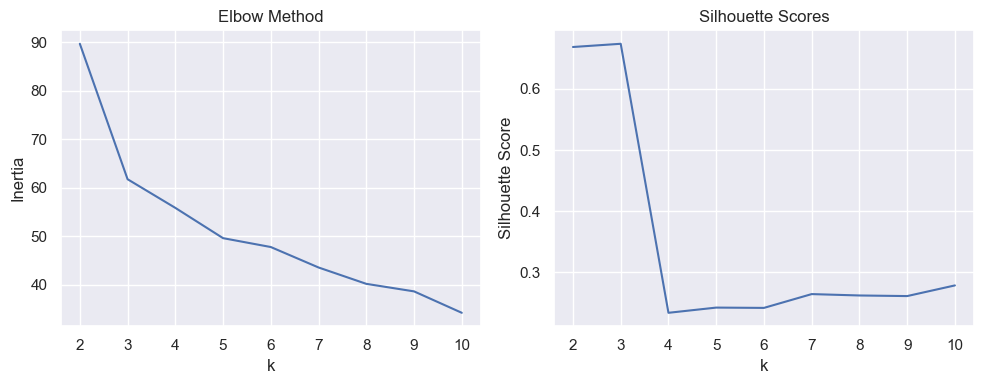

In [29]:
inertias = []
sil_scores = []
K_values = range(2, 11)

best_silhouette_score = -1
best_k = None

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(weights_2d)
    inertias.append(kmeans.inertia_)
    sil = silhouette_score(weights_2d, labels)
    sil_scores.append(sil)
    if sil > best_silhouette_score:
        best_silhouette_score = sil
        best_k = k

print(f"Optimal number of clusters (k): {best_k}")
print(f"Silhouette Score for k={best_k}: {best_silhouette_score:.3f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_values, inertias)
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_values, sil_scores)
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

With the both graphs we can see that the optimal number of clusters is 4. We are going to analyse other methods to confirm the final number of clusters.

### 3.3.3. U-Matrix using the trained SOM

The U-Matrix (Unified Distance Matrix) is a visualization used to represent the distances between neurons and highlights the boundaries between different clusters of data points. 
- Darker regions in the U-Matrix represent large distances (indicating boundaries between clusters)
- Lighter regions indicate small distances (showing areas of similarity)

In [30]:
u_matrix = som.distance_map()  

In [31]:
M, N = som.get_weights().shape[:2] 
final_weights = som.get_weights().reshape(M*N, -1)  

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(final_weights)

In [32]:
from collections import defaultdict

cluster_coords = defaultdict(list)

for i in range(M):
    for j in range(N):
        neuron_index = i*N + j
        cluster_id = labels[neuron_index]
        x, y = convert_map_to_euclidean(i, j)
        cluster_coords[cluster_id].append((x, y))

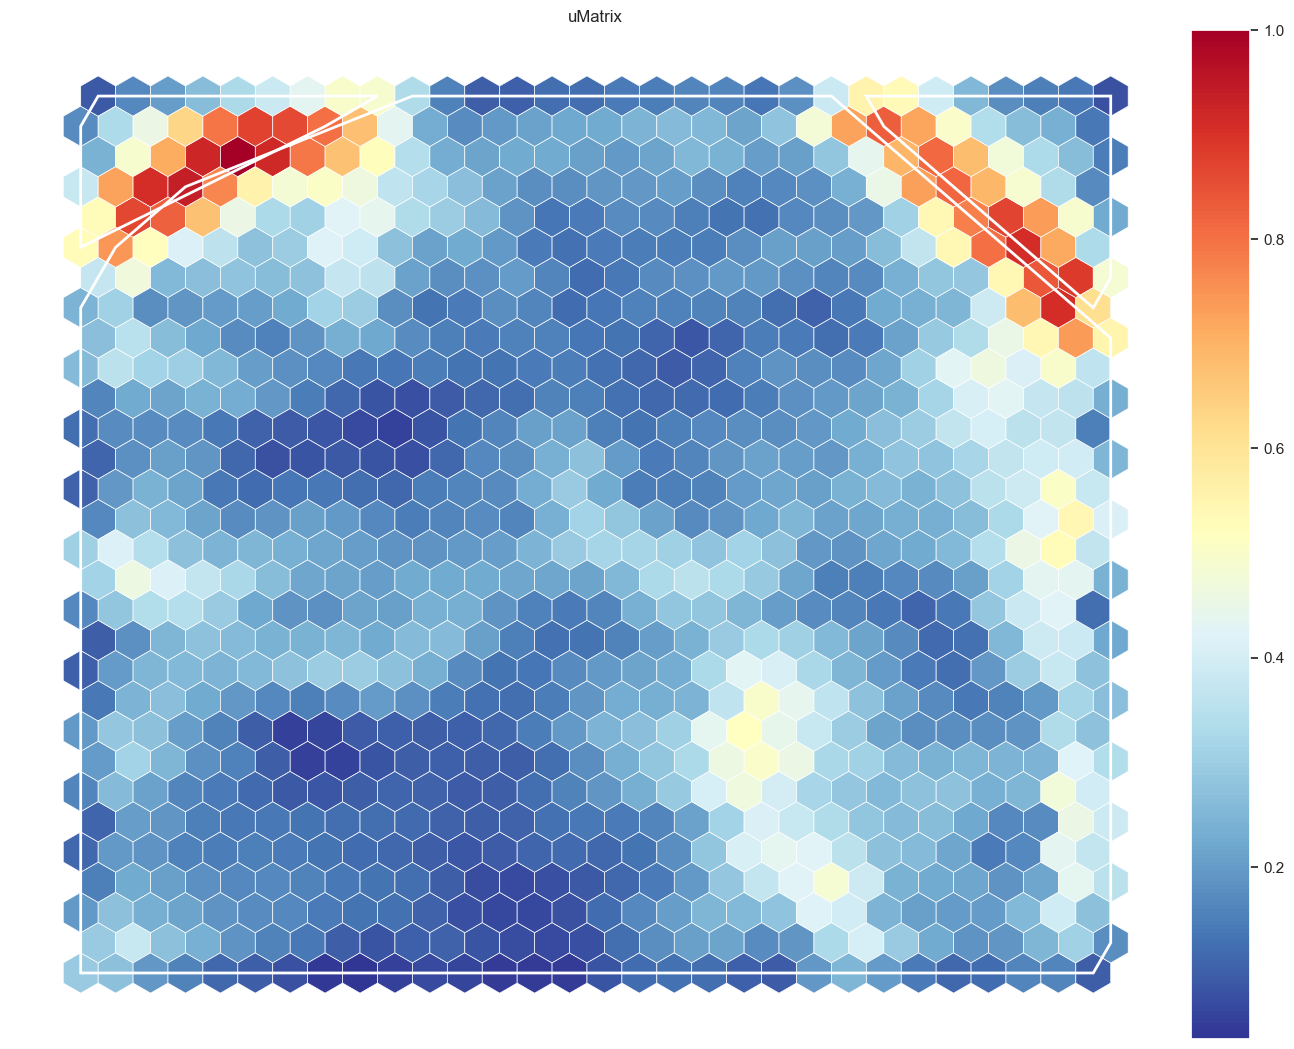

In [33]:
from shapely.geometry import Point, MultiPoint
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(16, 16))

colornorm = Normalize(vmin=u_matrix.min(), vmax=u_matrix.max())

plot_hexagons(ax, colornorm, u_matrix, label="uMatrix", annot=False, cmap=cm.RdYlBu_r)

for cluster_id, coords in cluster_coords.items():
    if not coords:
        continue

    if len(coords) < 3:
        x_c, y_c = np.mean([x for x, _ in coords]), np.mean([y for _, y in coords])
        circ = plt.Circle((x_c, y_c), radius=0.3, fill=False, color='red', linewidth=2)
        ax.add_patch(circ)
        continue

    points = MultiPoint([Point(x, y) for (x, y) in coords])
    hull = points.convex_hull  

    if hull.geom_type == 'Polygon':
        hull_x, hull_y = hull.exterior.xy
        hull_coords = np.vstack((hull_x, hull_y)).T 
        
        poly = Polygon(
            hull_coords,
            fill=False,
            edgecolor='white',
            linewidth=2
        )
        ax.add_patch(poly)
    elif hull.geom_type == 'LineString':
        lx, ly = hull.xy
        ax.plot(lx, ly, color='red', linewidth=2)

plt.show()

The yellow and orange regions represent areas where there is a significant difference (distance) between neighboring neurons, indicating distinct clusters of preferences. <br>
The blue areas represent regions where there is minimal difference between the neurons, representing a homogeneous preference within that cluster.

### 3.3.4. Hits Map


The Hit Map visualizes the number of times a neuron is the Best Matching Unit for a given input data point. This allows us to see which neurons are more active in representing the data and which ones are less active.

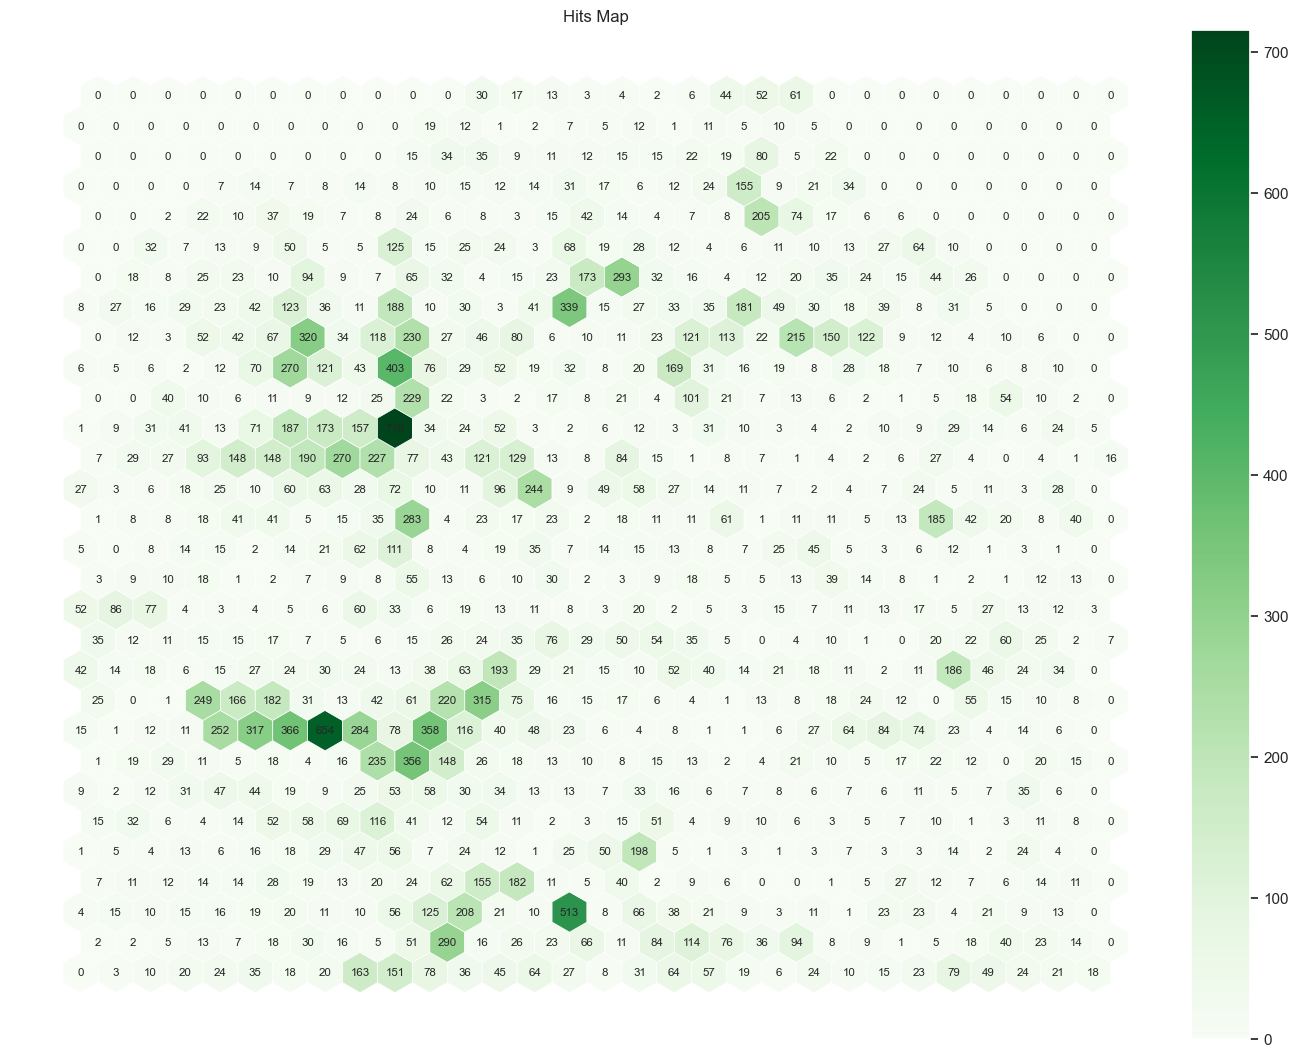

In [34]:
from matplotlib.colors import Normalize, LinearSegmentedColormap

def plot_hits_map_hex(som, data, title="Hits Map"):
    M, N = som.get_weights().shape[:2]
    hits_map = np.zeros((M, N))
    
    for _, sample in data.iterrows():
        sample = sample.values
        i, j = som.winner(sample)
        hits_map[i, j] += 1
    
    colornorm = Normalize(vmin=0, vmax=hits_map.max())
    fig, ax = plt.subplots(figsize=(16, 16))
    plot_hexagons(ax=ax, colornorm=colornorm, matrix_vals=hits_map, label=title, annot=True, cmap=cm.Greens)
    plt.show()

plot_hits_map_hex(som, df_preferences)

High-Density Regions: indicate a very dense cluster of data points in these areas, where customers share highly similar spending patterns across the analyzed cuisines.

Low-Density and Sparse Regions: composed by the three corners (top left, bottom left and bottom right): contain mostly low-hit neurons, suggesting that fewer data points are mapped here. They might be representing outliers in spending behavior.

### 3.3.6. K-Means on top of SOM units

KMeans clustering is applied on the trained SOM’s weights. This combines the spatial organization of SOM with the clustering of KMeans.

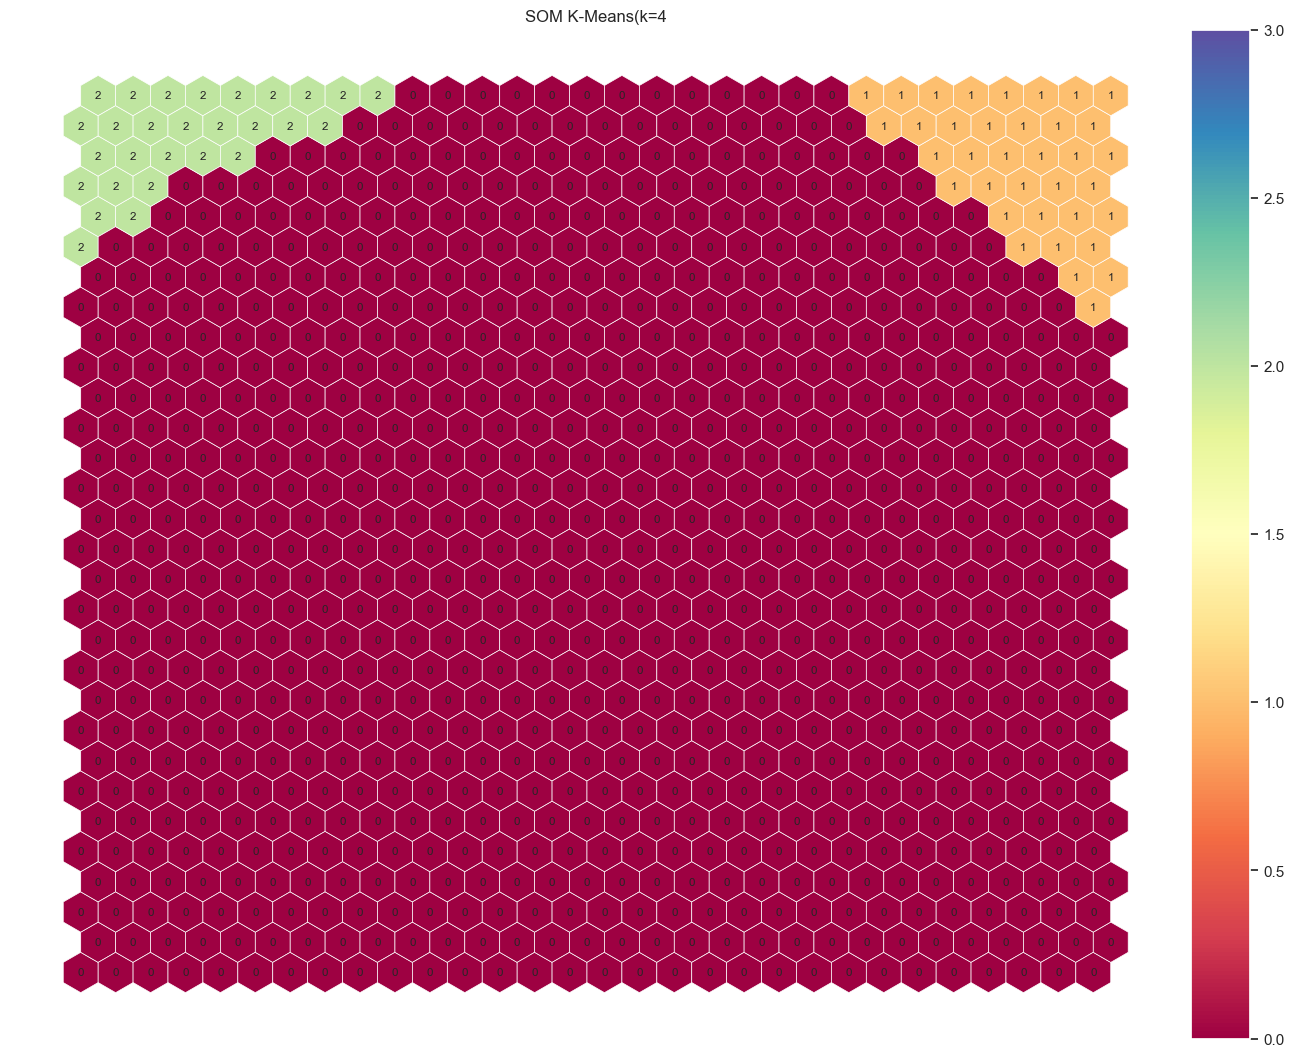

In [35]:
import matplotlib.colors as colors

weights_3d = som.get_weights() 
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M*N, num_features)

k = 4
# k = 3
kmeans_preferences = KMeans(n_clusters=k, init='k-means++', random_state=42)
nodeclus_labels_preferences = kmeans_preferences.fit_predict(weights_2d)

cluster_map = labels.reshape(M, N)

fig, ax = plt.subplots(figsize=(16, 16))

norm = colors.Normalize(vmin=0, vmax=k-1)

plot_hexagons(ax=ax, colornorm=norm, matrix_vals=cluster_map, label=f"SOM K-Means(k={k}", annot=True, cmap=cm.Spectral)
plt.show()

- We have smaller sections (like Orange) indicating distinct niche preferences. 
- The Purple region appears as a compact cluster with very concentrated data points, suggesting a unique spending behaviour.
- The larger section dominates the SOM grid, covering a large majority of neurons. It represents a homogeneous and dominant group in the dataset, indicating common spending patterns across various cuisines.

### 3.3.7. Hierarchical Clustering on top of SOM units

Hierarchical Clustering techniques (e.g., Agglomerative Clustering) are applied to the SOM’s weights, allowing for a hierarchical structure of clusters.

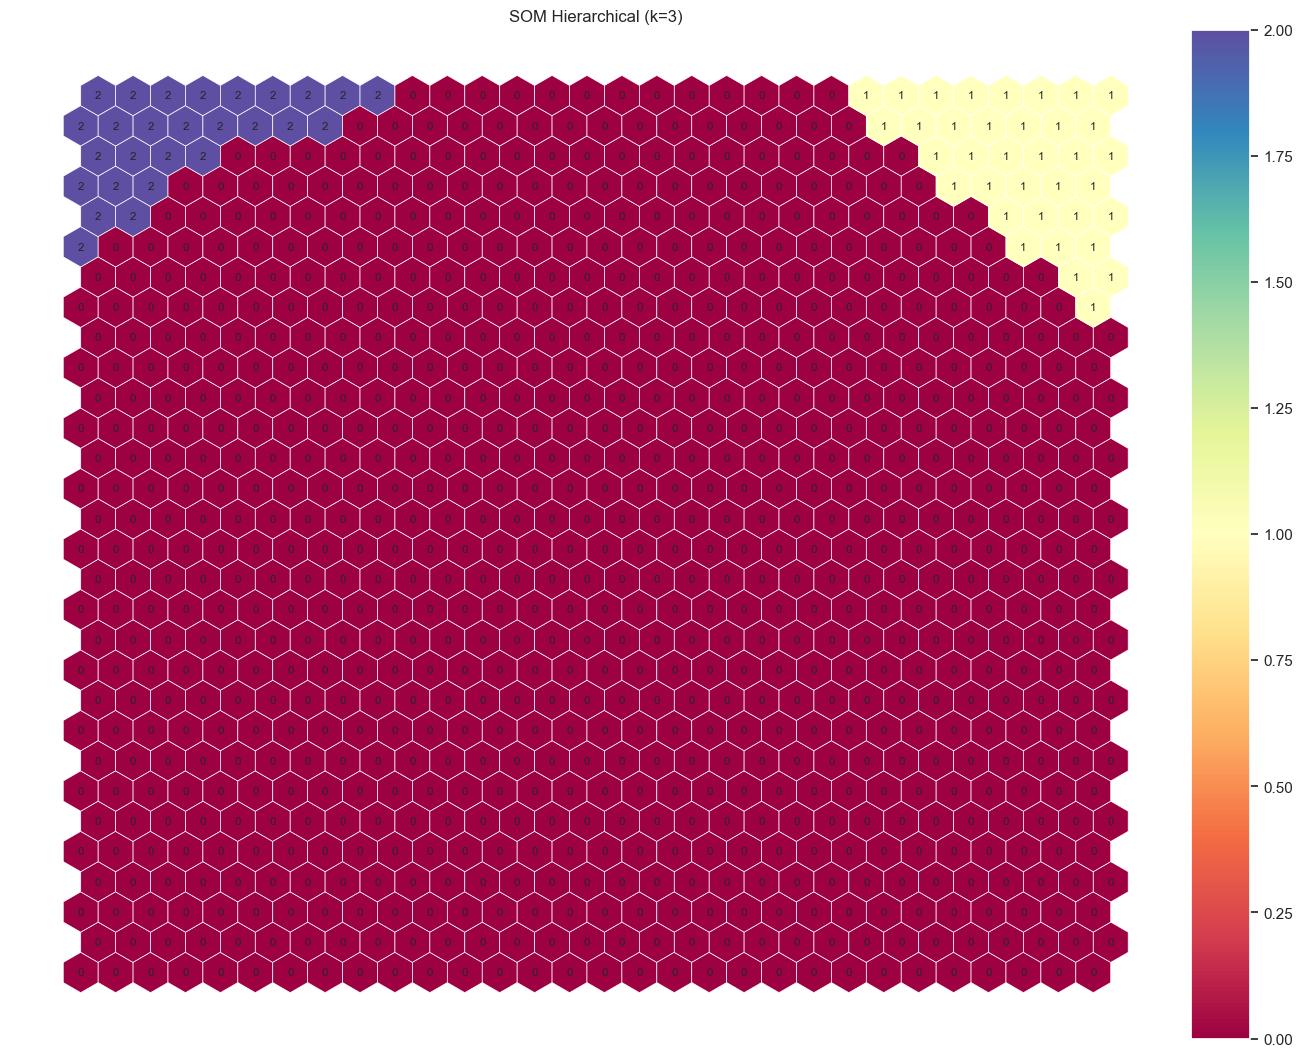

In [36]:
from sklearn.cluster import AgglomerativeClustering

weights_3d = som.get_weights()
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M * N, num_features)

k = 3
hc = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')

hc_labels = hc.fit_predict(weights_2d)

cluster_map = hc_labels.reshape(M, N)

fig, ax = plt.subplots(figsize=(16, 16))
norm = plt.Normalize(vmin=0, vmax=k-1)

plot_hexagons(ax=ax, colornorm=norm, matrix_vals=cluster_map, label=f"SOM Hierarchical (k={k})", annot=True, cmap=plt.cm.Spectral)
plt.show()

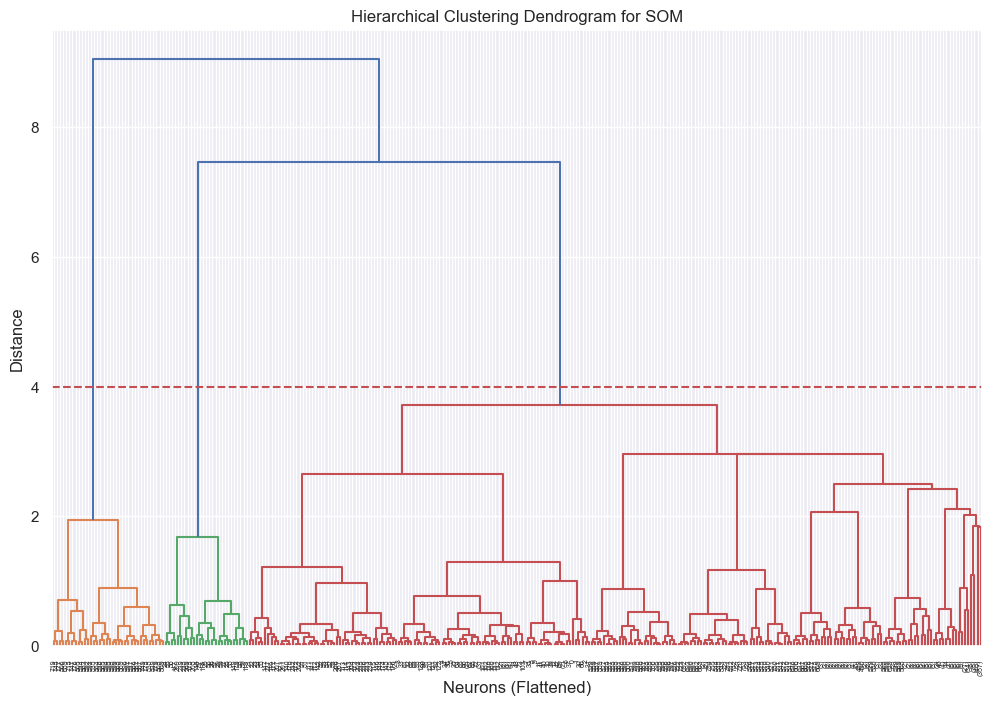

In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram

weights_3d = som.get_weights()
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M * N, num_features)

linkage_matrix = linkage(weights_2d, method='ward', metric='euclidean')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.axhline(y=4, color='r', linestyle='--')
plt.title('Hierarchical Clustering Dendrogram for SOM')
plt.xlabel('Neurons (Flattened)')
plt.ylabel('Distance')
plt.show()

### 3.3.8. Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index for different approaches of clustering 

#### SOM with KMeans

In [38]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# SOM with KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(weights_2d)
weights_df = pd.DataFrame(weights_2d)

sil_kmeans = silhouette_score(weights_2d, kmeans_labels, metric='euclidean')
dbi_kmeans = davies_bouldin_score(weights_2d, kmeans_labels)
ch_kmeans = calinski_harabasz_score(weights_2d, kmeans_labels)

r2 = get_r2(weights_df, kmeans_labels)

print("SOM with KMeans Clustering:")
print(f"Silhouette Score: {sil_kmeans:.3f}")
print(f"Davies-Bouldin Index: {dbi_kmeans:.3f}")
print(f"Calinski-Harabasz Index: {ch_kmeans:.3f}")
print(f"R^2 Score: {r2:.3f}")

new_row_kmeans = pd.DataFrame({"Silhouette_Score": [sil_kmeans], "R2": [r2]}, index=["SOM_KMeans_4"])
results_df = pd.concat([results_df, new_row_kmeans], axis=0, ignore_index=False)

SOM with KMeans Clustering:
Silhouette Score: 0.234
Davies-Bouldin Index: 1.099
Calinski-Harabasz Index: 400.020
R^2 Score: 0.573


1. Silhouette Score (0.234):
- The Silhouette Score measures how well-separated and cohesive the clusters are.
- The score suggests that the clusters are weakly separated or moderately overlapping.

2. Davies-Bouldin Index (1.099):
- The Davies-Bouldin Index (DBI) measures the compactness and separation of clusters.
- The score indicates good clustering as values near 1 often suggest well-formed clusters. However, cluster separation can be improved.

3. Calinski-Harabasz Index (400.020):
- The Calinski-Harabasz Index (CH) measures the variance between and within clusters.
- The score indicates good clustering quality.

#### SOM with Hierachical Clustering

In [39]:
# SOM with Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=4, linkage='ward', metric='euclidean')
hc_labels = hc.fit_predict(weights_2d)
weights_df = pd.DataFrame(weights_2d)

sil_hc = silhouette_score(weights_2d, hc_labels, metric='euclidean')
dbi_hc = davies_bouldin_score(weights_2d, hc_labels)
ch_hc = calinski_harabasz_score(weights_2d, hc_labels)

r2 = get_r2(weights_df, hc_labels)

print("\nSOM with Hierarchical Clustering:")
print(f"Silhouette Score: {sil_hc:.3f}")
print(f"Davies-Bouldin Index: {dbi_hc:.3f}")
print(f"Calinski-Harabasz Index: {ch_hc:.3f}")
print(f"R^2 Score: {r2:.3f}")

new_row_hc = pd.DataFrame({"Silhouette_Score": [sil_hc], "R2": [r2]}, index=["SOM_Hierarchical_4"])
results_df = pd.concat([results_df, new_row_hc], axis=0, ignore_index=False)


SOM with Hierarchical Clustering:
Silhouette Score: 0.261
Davies-Bouldin Index: 1.108
Calinski-Harabasz Index: 412.053
R^2 Score: 0.580


1. Silhouette Score (0.261):
- SOM with HC is slightly better at separating clusters. However, both methods still indicate weak separation.

2. Davies-Bouldin Index (1.108):
- SOM with KMeans performs slightly better as the DBI is slightly lower.

3. Calinski-Harabasz Index (412.053):
- SOM with HC performs better, indicating more distinct and compact clusters with greater inter-cluster separation.

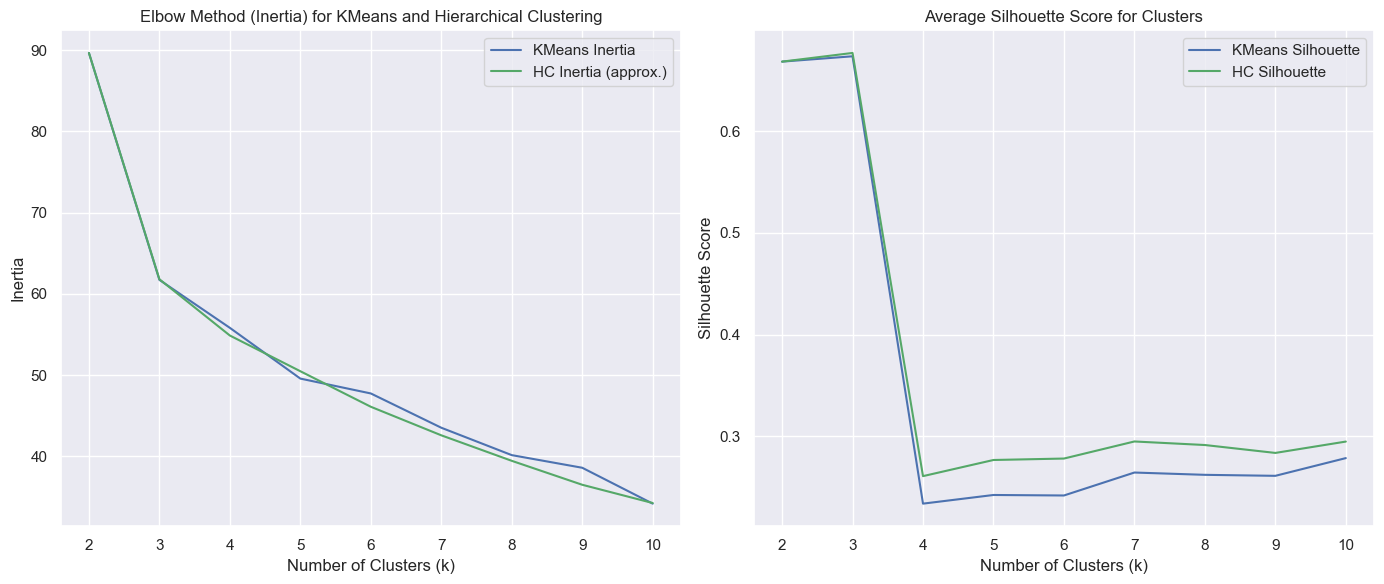

In [40]:
weights_3d = som.get_weights()
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M * N, num_features)

k_range = range(2, 11)
inertia_hc = [] 
inertia_kmeans = []
silhouette_kmeans = []
silhouette_hc = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(weights_2d)
    
    inertia_kmeans.append(kmeans.inertia_)
    silhouette_kmeans.append(silhouette_score(weights_2d, kmeans_labels, metric='euclidean'))

for k in k_range:
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    hc_labels = hc.fit_predict(weights_2d)
    
    inertia_sum = 0
    for cluster in range(k):
        cluster_points = weights_2d[hc_labels == cluster]
        cluster_center = cluster_points.mean(axis=0)
        inertia_sum += np.sum((cluster_points - cluster_center) ** 2)
    inertia_hc.append(inertia_sum)
    
    silhouette_hc.append(silhouette_score(weights_2d, hc_labels, metric='euclidean'))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_kmeans, color='b', label="KMeans Inertia")
plt.plot(k_range, inertia_hc, color='g', label="HC Inertia (approx.)")
plt.title("Elbow Method (Inertia) for KMeans and Hierarchical Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_kmeans, color='b', label="KMeans Silhouette")
plt.plot(k_range, silhouette_hc, color='g', label="HC Silhouette")
plt.title("Average Silhouette Score for Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()

plt.tight_layout()
plt.show()


### 3.3.9 SOM Clustering - Final Solution 

In [41]:
# SOM with Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=4, linkage='ward', metric='euclidean')
hc_labels = hc.fit_predict(weights_2d)
weights_df = pd.DataFrame(weights_2d)

In [42]:
# nodes_preferences = weights_2d

# df_nodes_preferences = pd.DataFrame(nodes_preferences, columns=df_preferences.columns)
# df_nodes_preferences['label'] = nodeclus_labels_preferences
# df_nodes_preferences

In [43]:
# n_clusters = 4
# hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')  
# bmu_index_preferences = [som.winner(sample) for sample in df_preferences.values]
# # bmu_index_preferences

In [44]:
# hier_map = hier_labels.reshape(M, N)  
# som_final_labels_preferences = [hier_map[i, j] for (i, j) in bmu_index_preferences]
# print(som_final_labels_preferences)

In [45]:
# df_final_preferences = pd.concat([df_preferences, pd.Series(som_final_labels_preferences, name='label', index=df_preferences.index)], axis=1)
# df_final_preferences

In [46]:
# df_final_preferences[df_preferences.columns.tolist()+['label']].groupby('label').mean()

<a class="anchor" id="mean">
    
## 3.4. Mean Shift Clustering
</a>

### 3.4.1. MSC - Defining the bandwith
Bandwidth is the window size used for the kernel density estimation.
This code estimates the optimal bandwidth to be used in Mean Shift clustering by considering the 40% closest points in the dataset, this will help understand around which values we should try the bandwidth around (a higher quantile means that we will have more points in the same clustering.

In [47]:
bandwidth = estimate_bandwidth(df_preferences, quantile=0.4, random_state=1, n_jobs=-1)
bandwidth

0.22066932330398237

In [48]:
bandwidths = np.arange(0.3, 0.4, 0.03) 
results = []

for bw in bandwidths:
    ms = MeanShift(bandwidth=bw, bin_seeding=True, n_jobs=4)
    ms_labels = ms.fit_predict(df_preferences)
    num_clusters = len(np.unique(ms_labels))

    df_preferences_with_labels = pd.concat([df_preferences, pd.Series(ms_labels, name='labels', index=df_preferences.index)], axis=1)
    
    sil_score = silhouette_score(df_preferences, ms_labels)
    
    r2_mean = get_r2(df_preferences, ms_labels)
    
    results.append((bw, num_clusters, sil_score, r2_mean))
    
    print(f"Bandwidth: {bw:.3f}, Number of Clusters: {num_clusters}, Silhouette Score: {sil_score:.3f}, R²: {r2_mean:.4f}")

Bandwidth: 0.300, Number of Clusters: 7, Silhouette Score: 0.532, R²: 0.0795
Bandwidth: 0.330, Number of Clusters: 4, Silhouette Score: 0.566, R²: 0.0534
Bandwidth: 0.360, Number of Clusters: 3, Silhouette Score: 0.597, R²: 0.0276
Bandwidth: 0.390, Number of Clusters: 3, Silhouette Score: 0.597, R²: 0.0276


### 3.4.2. MSC - Optimal amount of clusters
From the previous code, we conclude the best bandwith would be 0.330 because it has the best equilibrium between silhouete score and R². So we apply this to the following code.

In [49]:
ms = MeanShift(bandwidth=0.360, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_preferences)

In [50]:
df_preferences_labels = pd.concat([df_preferences, pd.Series(ms_labels, index=df_preferences.index, name="ms_labels")], axis=1)

df_concat = pd.concat([df_preferences, pd.Series(ms_labels, name='labels', index=df_preferences.index)], axis=1)
df_grouped = df_concat.groupby('labels').mean()
df_grouped

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  \
labels                                                                         
0           0.036677   0.038830       0.014499  0.006129            0.011768   
1           0.023852   0.146455       0.018086  0.000000            0.000000   
2           0.034965   0.052858       0.020714  0.000000            0.001264   

        CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  \
labels                                                                    
0          0.008621      0.007571     0.008968    0.010760     0.016283   
1          0.006194      0.013252     0.007004    0.000000     0.000000   
2          0.035056      0.590816     0.003650    0.001905     0.000840   

        CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_Street Food / Snacks  \
labels                                                                         
0           0.022242           0.005608   0.022697                  0.014885   
1           0.028780           0.000000   0.000000                  0.699475   
2           0.003477           0.000000   0.010087                  0.018936   

        CUI_Thai  
labels            
0       0.010722  
1       0.000000  
2       0.000000

In [51]:
r2 = get_r2(df_preferences, ms_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_preferences, ms_labels)
print(f"Silhouette Score: {silhouete}")

mean = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["Mean-Shift_6"])
results_df = pd.concat([results_df, mean], axis=0, ignore_index=False)

R² Score: 0.027637481330156154
Silhouette Score: 0.5966896553296385


<a class="anchor" id="dbscan">
    
## 3.5. DBSCAN
</a>

### 3.5.1. DBSCAN - determine the eps
To understand the best eps value for our DBSCAN, we do a K-Distance graph:
- The **K-Distance graph** shows how the distance to the 20th nearest neighbor changes for each point.
- On the left, the distances are small, meaning points are close and form dense clusters.
- To the right, the distances increase, indicating points are becoming more spread out and sparse.
- The **"elbow"** is where the graph's slope increases sharply — this marks the transition from dense clusters to sparse points.

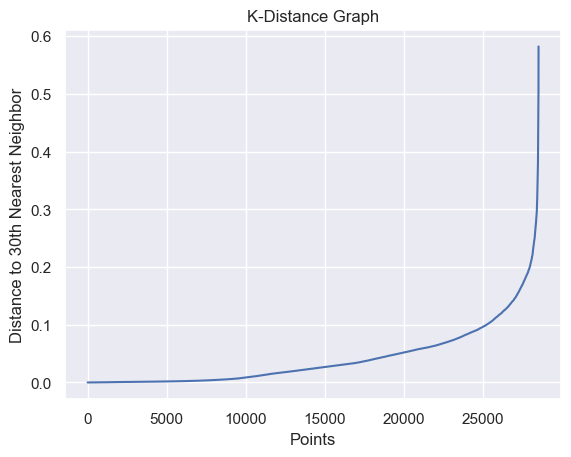

In [52]:
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_preferences)

distances, _ = neigh.kneighbors(df_preferences)
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to 30th Nearest Neighbor')
plt.title('K-Distance Graph')
plt.show()

### 3.5.2. DBSCAN - optimal number
From the previous graph we are able to conclude that the ideal **`eps`** is around 0.1 and 0.2 eps, so we choose 0.15 for this variable.

In [53]:
dbscan = DBSCAN(eps=0.15, min_samples=30, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_preferences)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


This clustering won't be used nor analysed further because:
- Too computationaly expensive
- The results are not the best (forms 2 clusterings, one of noise and the other one of not noise)
- Its biggest strenght is being used in the removal of outliers.

<a class="anchor" id="gmm">
    
## 3.6. Gaussian Mixture
</a>

### 3.6.1. GMM - Determining number of clusters
For this we will use a plot that determines the optimal number of components (`n_components`) for a Gaussian Mixture Model (GMM) by comparing the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).
  - **X-axis**: Represents the number of components in the GMM, ranging from 1 to 15.  
  - **Y-axis**: Shows the AIC and BIC scores. Lower values on the y-axis indicate better models based on the respective criteria.  

- **AIC (Akaike Information Criterion)**:  
  - Measures the goodness of fit while penalizing for model complexity.  
  - Lower AIC values signify a better balance between model complexity and fit.

- **BIC (Bayesian Information Criterion)**:  
  - Similar to AIC but applies a stronger penalty for complexity, favoring simpler models.  
  - Lower BIC values indicate the preferred model under this criterion.

- **Elbow Point in the Curve**: at **4 components**, because it's where the curve starts to flatten, suggesting that adding more components beyond this range provides diminishing improvements in model fit.

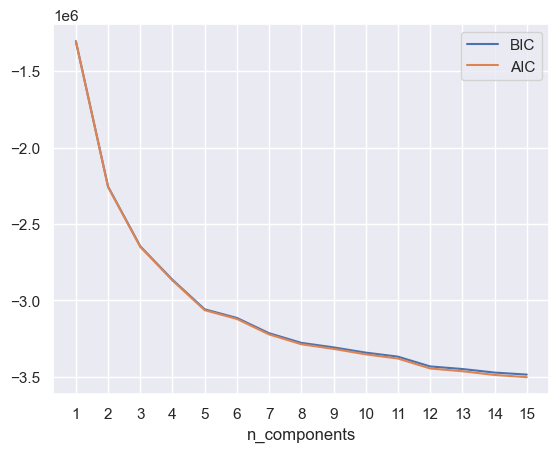

In [54]:
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_preferences)
          for n in n_components]

bic_values = [m.bic(df_preferences) for m in models]
aic_values = [m.aic(df_preferences) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

### 3.6.2 GMM - Optimal number of clusters
As previously seen the optimal number of clusters for this algorithm is 4, this way we will continue with this value.

In [55]:
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_preferences)

In [56]:
#proportion of the data that belongs to each cluster
gmm.weights_

array([0.28068066, 0.51361798, 0.20570136])

In [57]:
df_concat = pd.concat([df_preferences, pd.Series(gmm_labels, name='gmm_labels', index=df_preferences.index)], axis=1)
df_grouped = df_concat.groupby('gmm_labels').mean()
df_grouped

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  \
gmm_labels                                                     
0               0.027731   0.050137       0.044042  0.000002   
1               0.047442   0.044901       0.000006  0.000000   
2               0.021885   0.009073       0.010475  0.029708   

            CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts   CUI_Healthy  \
gmm_labels                                                                
0                 0.000000e+00     0.019610  2.847968e-02  2.171936e-02   
1                 4.963348e-07     0.000002  4.981823e-07  4.334395e-07   
2                 5.705889e-02     0.015389  3.359727e-03  1.391198e-02   

            CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  \
gmm_labels                                                             
0             0.000008     0.000018       0.01756       0.000000e+00   
1             0.015805     0.026579       0.02795       6.817324e-07   
2             0.012676     0.012505       0.01424       2.718406e-02   

            CUI_OTHER  CUI_Street Food / Snacks  CUI_Thai  
gmm_labels                                                 
0            0.004931                  0.054278  0.000000  
1            0.026068                  0.000004  0.015266  
2            0.038252                  0.002894  0.013830

In [58]:
r2 = get_r2(df_preferences, gmm_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_preferences, gmm_labels)
print(f"Silhouette Score: {silhouete}")
mean = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["Gaussian Mixture_3"])
results_df = pd.concat([results_df, mean], axis=0, ignore_index=False)

R² Score: 0.05986655143400744
Silhouette Score: 0.04903787566925925


## 3.7. Clustering assessment
To measure the different clustering algorithms used, we use the following metrics:
- **R²:** explains how well the clustering algorithm explains the variance in the data. A higher R² value indicates that the clustering model better fits the data, with fewer unexplained variations.
- **Sillhouete Score:** measures how similar each point is to its own cluster compared to other clusters. It ranges from -1 to +1, where a score closer to +1 indicates well-defined clusters, and values closer to -1 suggest poor clustering. A higher silhouette score generally implies better clustering quality.
- **Amount of clusters**: Besides fewer clusters being more able to generalize the data rather than overfit it, it makes the model simpler. As the only options chosen from the previous clusterings were 4 or 6 clusters, this variable has a small weight in the decision of which clustering to use,

This way, we want to choose the clustering algorithm that shows the best balance between the three metrics.
- R²:Weight = 0.35 as this value measures how well the clustering algorithm explains the variance in the data. However, it's not the ebst metric to evaluate the clustering because it always tends to increase with more clusters and it doesn´t account for meaningfulness or separation of the clusters.

- Silhouete score: Weight = 0,55 as it is a better evaluation metric than R² because it measures how well each data point fits into its own cluster relative to other clusters. this way, evaluating if the clustering fits the data and if similar points are together.

- Number of clusters: Weight = 0,2 as the only options chosen from the previous clusterings were 4 or 6 clusters, this variable has a small weight in the decision of which clustering to use.

In [64]:
results = results_df
results["Clusters"] = results.index.str.slice(-1).astype(int)  # Convert the index to float and assign it to 'Clusters'
# Normalize the Clusters column: invert the number of clusters (smaller is better)
results["Clusters_Inverted"] = 1 / results["Clusters"]

# Apply the weighted formula
results["Ranking"] = (results["Silhouette_Score"] * 0.85 + 
                       results["R2"] * 0.15 )

# Rank the results based on the new ranking (higher values = better ranks)
results["Rank"] = results["Ranking"].rank(ascending=False, method="min")

# Drop the temporary "Clusters_Inverted" column if not needed
results = results.drop(columns=["Clusters_Inverted", "Ranking" ])

# Display the result
results

results = results.sort_values(by=["Rank"], ascending=True)
results

Silhouette_Score        R2  Clusters  Rank
Mean-Shift_6                0.596690  0.027637         6   1.0
SOM_Hierarchical_4          0.261053  0.579769         4   2.0
SOM_KMeans_4                0.234032  0.572531         4   3.0
KMeans_6                    0.265768  0.337121         6   4.0
HC_3                        0.242959  0.134512         3   5.0
Gaussian Mixture_3          0.049038  0.059867         3   6.0

From this table we conclude that the best clustering algorithm for df_preferences is **SOM with Hierarchical Clustering** with **4 clusters**. Even though, MeanShift_6 appears in first place in the table, the really low R2-Score makes us not consider it for the next steps as this would mean really unproportional clusters and data not very well represented.
Furthermore, due to the computationally costs of SOM, and the similarity of the results between SOM and KMeans, the last one was the one chosen for further steps.